## import dependency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Input, Dense,MaxPooling2D, Flatten,Conv2D
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)    
    

In [4]:
POS_PATH=os.path.join('data','positive')
NEG_PATH=os.path.join('data','negative')
ANC_PATH=os.path.join('data','anchor')

## collecting negative data

In [5]:
import os

# Define the path to the directory where you want to move the files
NEG_PATH = 'data/negative'

# Ensure the NEG_PATH directory exists
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)

# Iterate over the directories and files in the 'lfw' directory
for directory in os.listdir('lfw'):
    dir_path = os.path.join('lfw', directory)
    if os.path.isdir(dir_path):  # Check if it is indeed a directory
        for file in os.listdir(dir_path):
            EX_PATH = os.path.join(dir_path, file)
            NEW_PATH = os.path.join(NEG_PATH, file)

            # Print paths to debug
            print(f'Moving {EX_PATH} to {NEW_PATH}')

            os.replace(EX_PATH, NEW_PATH)


## collecting positive and anchore data

In [6]:
import uuid

In [7]:
import cv2

# Initialize the video capture object with the correct device index
cap = cv2.VideoCapture(0)  # Try different indices if necessary (0, 1, 2, etc.)

if not cap.isOpened():
    print("Error: Could not open video device.")
else:
    print("Video device opened successfully.")
    while cap.isOpened():
        ret, frame = cap.read()
        frame=frame[120:120+250,200:200+250,:]
        ## collecting anchore
        if cv2.waitKey(1) & 0xFF == ord('a'):
            imgname=os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        ## collecting positive
        if cv2.waitKey(1) & 0xFF == ord('p'):
            imgname=os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
            cv2.imwrite(imgname,frame)
        if not ret:
            print("Error: Failed to capture image.")
            break
        # Check if the frame is empty
        if frame is None or frame.size == 0:
            continue
        cv2.imshow('Image Collection', frame)
        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the webcam and close all OpenCV windows
    cap.release()
    cv2.destroyAllWindows()


Video device opened successfully.


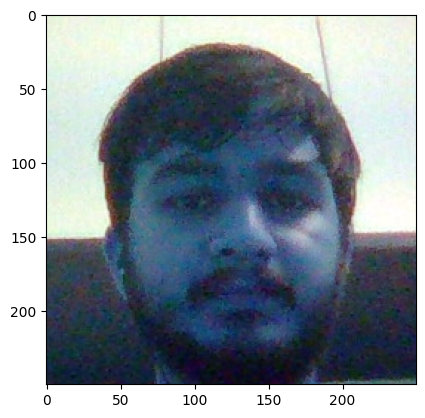

In [8]:
plt.imshow(frame[:,:,:])

In [9]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [10]:
dir_test = anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\af487a29-37bb-11ef-8472-fc349794977f.jpg'


In [12]:
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img = preprocess('data\\anchor\\ac0a02c6-37bb-11ef-8c9a-fc349794977f.jpg')

In [14]:
img.numpy().max()

0.88284314

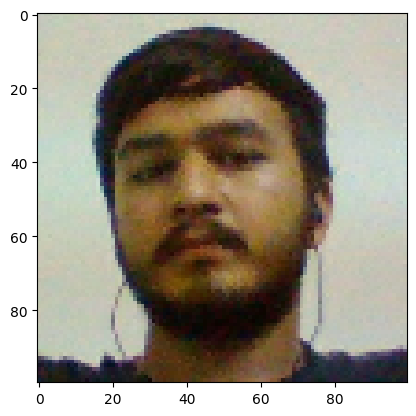

In [15]:
plt.imshow(img)

In [16]:
# (anchore , positive ) => 1,1,1,1,1
# (anchore , negative )=> 0,0,0,0,0

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [19]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [20]:
exampple

(b'data\\anchor\\ace8b939-37bb-11ef-b8ac-fc349794977f.jpg',
 b'data\\positive\\c943d5eb-37bb-11ef-9dde-fc349794977f.jpg',
 1.0)

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
res = preprocess_twin(*exampple)


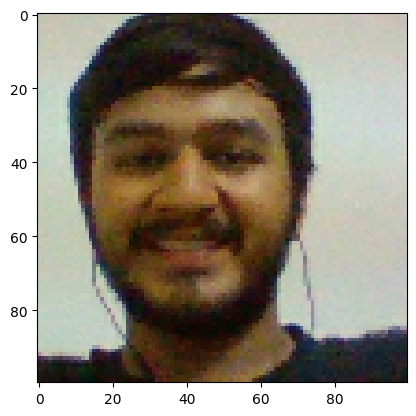

In [23]:
plt.imshow(res[1])

In [24]:
res[2]

1.0

## Build dataloader pipline

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)

In [26]:
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [27]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [28]:
samples=data.as_numpy_iterator()

In [29]:
len(samples.next())

3

In [30]:
samp=samples.next()

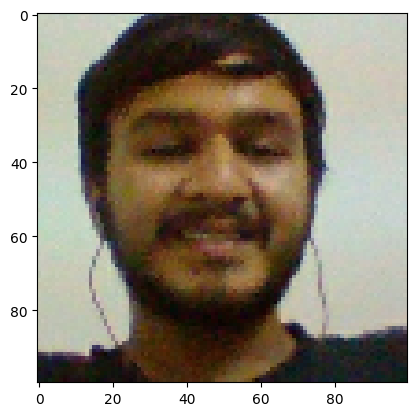

In [31]:
plt.imshow(samp[1])

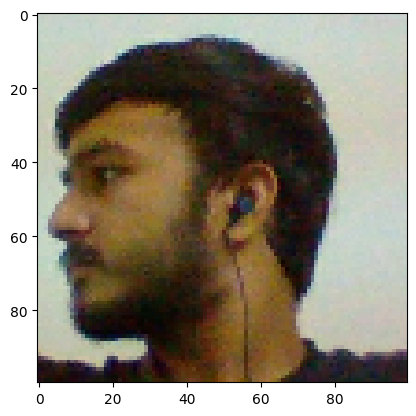

In [32]:
plt.imshow(samp[0])

In [33]:
samp[2]

1.0

In [34]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [35]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# model engineering

In [41]:
# inp=Input(shape=(100,100,3),name='input_image')
# #first block
# c1=Conv2D(64,(10,10),activation='relu')(inp)
# m1=MaxPooling2D(64,(2,2),padding='same')(c1)
# # second block
# c2=Conv2D(128,(7,7),activation='relu')(m1)
# m2=MaxPooling2D(64,(2,2),padding='same')(c2)
# # third Block
# c3=Conv2D(128,(4,4),activation='relu')(m2)
# m3=MaxPooling2D(64,(2,2),padding='same')(c3)
# # final block
# c4=Conv2D(256,(4,4),activation='relu')(m3)
# f1=Flatten()(c4)
# d1=Dense(4096,activation='sigmoid')(f1)
# mod=Model(inputs=[inp],outputs=[d1],name='embedding')
# mod.summary()

In [62]:
def make_embedding():
    inp=Input(shape=(100,100,3),name='input_image')
    #first block
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)
    # second block
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)
    # third Block
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)
    # final block
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
        
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [67]:
embedding=make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 17, 17, 128)       26

In [91]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)

In [92]:
l1=L1Dist()

In [93]:
def make_siamese_model():
    input_image=Input(name='input_image',shape=(100,100,3))
    validation_input=Input(name='validation_input',shape=(100,100,3))
    siamese_layer=L1Dist()
    siamese_layer._name='distance'
    distance=siamese_layer(embedding(input_image),embedding(validation_input))
    classifier=Dense(1,activation='sigmoid')(distance)
    return Model(inputs=[input_image,validation_input],outputs=classifier,name='SiameseNetwork')
    

In [94]:
siamese_Model=make_siamese_model()
siamese_Model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_input (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_input[0